<h1>3D Model Reconstruction in Polyphy</h1>
<h1>DO NOT USE 'RUN ALL' - THERE ARE BLOCKING CELLS IN THIS NOTEBOOK</h1>

<h1> Install Dependencies and Import Libraries</h1>

In [ ]:
!pip install -r ../../../requirements.txt

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.filters import threshold_local
from scipy.ndimage import *
import pyvista as pv
import mcubes
import ipywidgets as widgets
import math
from enum import IntEnum
from numpy.random import default_rng
import time
from datetime import datetime
import matplotlib.pyplot as plt
import scipy
import taichi as ti
import taichi.math as timath
import trimesh
import collada
import fast_simplification

[Taichi] version 1.6.0, llvm 15.0.7, commit f1c6fbbd, osx, python 3.10.16


[I 04/19/25 13:39:27.699 3317877] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


<h1> Define PolyPhy Directory and Load Mesh for Reconstruction </h1>

In [2]:
# Location of your Polyphy install
ROOT = "/Users/liuruichen/Developer/2025/PolyPhy"

In [4]:
try:
    # Location of mesh you want to use with Polyphy
    stl_name = "Bunny.stl"
    fname1 = ROOT + "/data/stl/"+stl_name
    mesh = pv.read(fname1)
    mesh = mesh.scale([5,5,5])
except:
    print("File not found - please add your STL file to the /data/stl folder and change the value of stl_name to that filename")

<h1> Voxelization with pyvista </h1>

In [5]:
#Takes the mesh and voxelizes it, turning it into a array of binary values showing which points are in the shape
#and which are not
def vox(meshname):
  #density informs how dense the voxelization will be and therefore how tight the formed networks will be. A higher density
  #will lead to thicker filaments, which is better for 3D printing
  density = mesh.length / 100
  x_min, x_max, y_min, y_max, z_min, z_max = mesh.bounds
  x = np.arange(x_min-8.0003, x_max+8.0003, density)
  y = np.arange(y_min-8.0003, y_max+8.0003, density)
  z = np.arange(z_min-8.0003, z_max+8.0003, density)
  #print(x.shape,y.shape,z.shape)
  x, y, z = np.meshgrid(x, y, z)
    
  # Create unstructured grid from the structured grid
  grid = pv.StructuredGrid(x, y, z)
  ugrid = pv.UnstructuredGrid(grid)

  # get part of the mesh within the mesh's bounding surface.
  selection = ugrid.select_enclosed_points(mesh.extract_surface(),
                                          tolerance=0.0,
                                          check_surface=False)
  mask = selection.point_data['SelectedPoints'].view(bool)
  mask = mask.reshape(x.shape)

  #print(mask.shape)
  np.save(fname1[:-4] + "_grid.npy",grid.points)
  np.save(fname1[:-4] + "_mask.npy", mask)

vox(mesh) 
print("Mesh voxelized successfully!")

Mesh voxelized successfully!


<h1> Polyphy Functions </h1>

In [6]:
## Type aliases
FLOAT_CPU = np.float32
INT_CPU = np.int32
FLOAT_GPU = ti.f32
INT_GPU = ti.i32

VEC2i = ti.types.vector(2, INT_GPU)
VEC3i = ti.types.vector(3, INT_GPU)
VEC2f = ti.types.vector(2, FLOAT_GPU)
VEC3f = ti.types.vector(3, FLOAT_GPU)

## Distance sampling distribution for agents
class EnumDistanceSamplingDistribution(IntEnum):
    CONSTANT = 0
    EXPONENTIAL = 1
    MAXWELL_BOLTZMANN = 2

## Directional sampling distribution for agents
class EnumDirectionalSamplingDistribution(IntEnum):
    DISCRETE = 0
    CONE = 1

## Sampling strategy for directional agent mutation
class EnumDirectionalMutationType(IntEnum):
    DETERMINISTIC = 0
    PROBABILISTIC = 1

## Deposit fetching strategy
class EnumDepositFetchingStrategy(IntEnum):
    NN = 0
    NN_PERTURBED = 1

## Handling strategy for agents that leave domain boundary
class EnumAgentBoundaryHandling(IntEnum):
    WRAP = 0
    REINIT_CENTER = 1
    REINIT_RANDOMLY = 2

In [7]:
## Data input file - leave empty for working with .stls for 3D reconstruction
INPUT_FILE = ''

## Simulation-wide constants
N_DATA_DEFAULT = 1000
N_AGENTS_DEFAULT = 1000000
DOMAIN_SIZE_DEFAULT = 100.0
TRACE_RESOLUTION_MAX = 512
DEPOSIT_DOWNSCALING_FACTOR = 1
STEERING_RATE = 0.5
MAX_DEPOSIT = 10.0
DOMAIN_MARGIN = 0.05
VIS_RESOLUTION = (1280, 720)
RAY_EPSILON = 1.0e-3
DEPOSIT_DENSITY_SCALAR = 256.0
DEPOSIT_DENSITY_SCALAR_RATIO = (float(TRACE_RESOLUTION_MAX)/DEPOSIT_DENSITY_SCALAR)**3.0
print("DEPOSIT_DENSITY_SCALAR_RATIO: ", DEPOSIT_DENSITY_SCALAR_RATIO)

## State flags
distance_sampling_distribution = EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN
directional_sampling_distribution = EnumDirectionalSamplingDistribution.CONE
directional_mutation_type = EnumDirectionalMutationType.PROBABILISTIC
deposit_fetching_strategy = EnumDepositFetchingStrategy.NN_PERTURBED
agent_boundary_handling = EnumAgentBoundaryHandling.WRAP

DEPOSIT_DENSITY_SCALAR_RATIO:  8.0


Shape of mask in voxels:(63, 51, 63)

Visualization of mask slice:


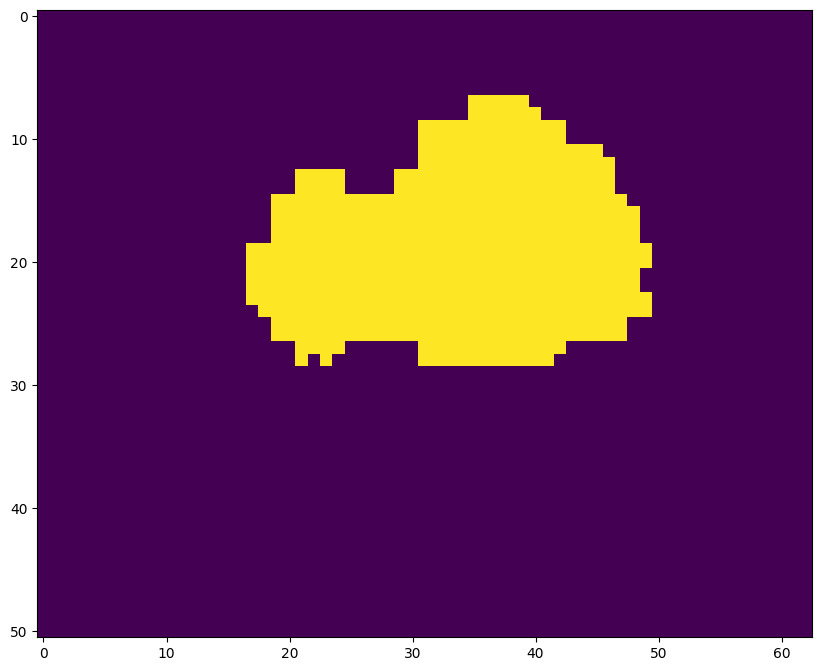

In [8]:
#This function takes the voxelized mesh from earlier and creates a 3D mask that defines the space the agents can travel in
#As a sanity check, a 2D slice of this mask is rendered below
def createMask(m):
    helmet_mask = np.load(m)
    #print(helmet_mask.shape)
    mask = helmet_mask.reshape(helmet_mask.shape[2], helmet_mask.shape[1], helmet_mask.shape[0],1).transpose([1, 2, 0, 3]).astype(FLOAT_CPU)
    #print(mask.shape, mask.dtype)
    
    #create 2D slice figure
    plt.figure(figsize = (10.0, 10.0))
    plt.imshow(mask[5,:,:])
    MASK_RESOLUTION = mask.shape[0:3]
    print("Shape of mask in voxels:" + str(MASK_RESOLUTION) + "\n")
    print("Visualization of mask slice:")
    return mask, MASK_RESOLUTION

mask, MASK_RESOLUTION = createMask(fname1[:-4] + "_mask.npy")

In [9]:
## Initialize Taichi
ti.init(arch=ti.cuda, device_memory_GB=10.0)
rng = default_rng()

## Initialize data and agents
data = None
DOMAIN_MIN = None
DOMAIN_MAX = None
DOMAIN_SIZE = None
DOMAIN_CENTER = None
N_DATA = None
N_AGENTS = N_AGENTS_DEFAULT
AVG_WEIGHT = 10.0

## Load data
## If no input file then generate a random dataset
if len(INPUT_FILE) > 0:
    data = np.loadtxt(INPUT_FILE, delimiter=",").astype(FLOAT_CPU)
    N_DATA = data.shape[0]
    domain_min = (np.min(data[:,0]), np.min(data[:,1]), np.min(data[:,2]))
    domain_max = (np.max(data[:,0]), np.max(data[:,1]), np.max(data[:,2]))
    domain_size = np.subtract(domain_max, domain_min)
    DOMAIN_MIN = (domain_min[0] - DOMAIN_MARGIN * domain_size[0], domain_min[1] - DOMAIN_MARGIN * domain_size[1], domain_min[2] - DOMAIN_MARGIN * domain_size[2])
    DOMAIN_MAX = (domain_max[0] + DOMAIN_MARGIN * domain_size[0], domain_max[1] + DOMAIN_MARGIN * domain_size[1], domain_max[2] + DOMAIN_MARGIN * domain_size[2])
    DOMAIN_SIZE = np.subtract(DOMAIN_MAX, DOMAIN_MIN)
    AVG_WEIGHT = np.mean(data[:,3])
else:
    N_DATA = N_DATA_DEFAULT
    N_AGENTS = N_AGENTS_DEFAULT
    domain_min = (0.0, 0.0, 0.0)
    domain_max = mask[:,:,:,0].shape
    domain_size = domain_max
    DOMAIN_MIN = (domain_min[0] - DOMAIN_MARGIN * domain_size[0], domain_min[1] - DOMAIN_MARGIN * domain_size[1], domain_min[2] - DOMAIN_MARGIN * domain_size[2])
    DOMAIN_MAX = (domain_max[0] + DOMAIN_MARGIN * domain_size[0], domain_max[1] + DOMAIN_MARGIN * domain_size[1], domain_max[2] + DOMAIN_MARGIN * domain_size[2])
    DOMAIN_SIZE = np.subtract(DOMAIN_MAX, DOMAIN_MIN)
    data = np.zeros(shape=(N_DATA, 4), dtype = FLOAT_CPU)
    data[:, 0] = rng.normal(loc = DOMAIN_MIN[0] + 0.5 * DOMAIN_MAX[0], scale = 0.1 * DOMAIN_SIZE[0], size = N_DATA)
    data[:, 1] = rng.normal(loc = DOMAIN_MIN[1] + 0.5 * DOMAIN_MAX[1], scale = 0.1 * DOMAIN_SIZE[1], size = N_DATA)
    data[:, 2] = rng.normal(loc = DOMAIN_MIN[2] + 0.5 * DOMAIN_MAX[2], scale = 0.1 * DOMAIN_SIZE[2], size = N_DATA)
    data[:, 3] = AVG_WEIGHT

## Derived constants
DOMAIN_CENTER = (0.5 * (DOMAIN_MIN[0] + DOMAIN_MAX[0]), 0.5 * (DOMAIN_MIN[1] + DOMAIN_MAX[1]), 0.5 * (DOMAIN_MIN[2] + DOMAIN_MAX[2]))
DATA_TO_AGENTS_RATIO = FLOAT_CPU(N_DATA) / FLOAT_CPU(N_AGENTS)
DOMAIN_SIZE_MAX = np.max([DOMAIN_SIZE[0], DOMAIN_SIZE[1], DOMAIN_SIZE[2]])
TRACE_RESOLUTION = INT_CPU((\
    FLOAT_CPU(TRACE_RESOLUTION_MAX) * DOMAIN_SIZE[0] / DOMAIN_SIZE_MAX,\
    FLOAT_CPU(TRACE_RESOLUTION_MAX) * DOMAIN_SIZE[1] / DOMAIN_SIZE_MAX,\
    FLOAT_CPU(TRACE_RESOLUTION_MAX) * DOMAIN_SIZE[2] / DOMAIN_SIZE_MAX))
DEPOSIT_RESOLUTION = (TRACE_RESOLUTION[0] // DEPOSIT_DOWNSCALING_FACTOR, TRACE_RESOLUTION[1] // DEPOSIT_DOWNSCALING_FACTOR, TRACE_RESOLUTION[2] // DEPOSIT_DOWNSCALING_FACTOR)

## Init agents
agents = np.zeros(shape=(N_AGENTS, 6), dtype = FLOAT_CPU)
agents[:, 0] = rng.uniform(low = DOMAIN_MIN[0] + 0.001, high = DOMAIN_MAX[0] - 0.001, size = N_AGENTS)
agents[:, 1] = rng.uniform(low = DOMAIN_MIN[1] + 0.001, high = DOMAIN_MAX[1] - 0.001, size = N_AGENTS)
agents[:, 2] = rng.uniform(low = DOMAIN_MIN[2] + 0.001, high = DOMAIN_MAX[2] - 0.001, size = N_AGENTS)
agents[:, 3] = np.arccos(2.0 * np.array(rng.uniform(low = 0.0, high = 1.0, size = N_AGENTS)) - 1.0) # zenith angle
agents[:, 4] = rng.uniform(low = 0.0, high = 2.0 * np.pi, size = N_AGENTS) # azimuth angle
agents[:, 5] = 1.0

print('Simulation domain min:', DOMAIN_MIN)
print('Simulation domain max:', DOMAIN_MAX)
print('Simulation domain size:', DOMAIN_SIZE)
print('Trace grid resolution:', TRACE_RESOLUTION)
print('Deposit grid resolution:', DEPOSIT_RESOLUTION)
print('Vis resolution:', VIS_RESOLUTION)
print('Data sample:', data[0, :])
print('Agent sample:', agents[0, :])
print('Number of agents:', N_AGENTS)
print('Number of data points:', N_DATA)

[Taichi] Starting on arch=arm64
Simulation domain min: (-3.1500000000000004, -2.5500000000000003, -3.1500000000000004)
Simulation domain max: (66.15, 53.55, 66.15)
Simulation domain size: [69.3 56.1 69.3]
Trace grid resolution: [512 414 512]
Deposit grid resolution: (512, 414, 512)
Vis resolution: (1280, 720)
Data sample: [33.366093 26.481266 30.066364 10.      ]
Agent sample: [-1.226815  36.95216   18.251387   0.9595414  3.9863973  1.       ]
Number of agents: 1000000
Number of data points: 1000


[W 04/19/25 13:39:56.098 3317877] [misc.py:adaptive_arch_select@753] Arch=[<Arch.cuda: 4>] is not supported, falling back to CPU


In [10]:
## Allocate GPU memory fields
## Keep in mind that the dimensions of these fields are important in the subsequent computations;
## that means if they change the GPU kernels and the associated handling code must be modified as well
data_field = ti.Vector.field(n = 4, dtype = FLOAT_GPU, shape = N_DATA)
agents_field = ti.Vector.field(n = 6, dtype = FLOAT_GPU, shape = N_AGENTS)
deposit_field = ti.Vector.field(n = 2, dtype = FLOAT_GPU, shape = DEPOSIT_RESOLUTION)
trace_field = ti.Vector.field(n = 1, dtype = FLOAT_GPU, shape = TRACE_RESOLUTION)
vis_field = ti.Vector.field(n = 3, dtype = FLOAT_GPU, shape = VIS_RESOLUTION)
mask_field = ti.Vector.field(n = 1, dtype = FLOAT_GPU, shape = MASK_RESOLUTION)
print('Total GPU memory allocated:', INT_CPU(4 * (\
    data_field.shape[0] * 4 + \
    agents_field.shape[0] * 6 + \
    deposit_field.shape[0] * deposit_field.shape[1] * deposit_field.shape[2] * 2 + \
    trace_field.shape[0] * trace_field.shape[1] * trace_field.shape[2] * 1 + \
    mask_field.shape[0] * mask_field.shape[1] * mask_field.shape[2] * 1 + \
    vis_field.shape[0] * vis_field.shape[1] * 3 \
    ) / 2 ** 20), 'MB')

Total GPU memory allocated: 1276 MB


In [11]:
## Define all GPU functions and kernels
#taken from taichi 1.0.3 since new taichi does not have it - all my homies love tech debt
@ti.func
def rotate3d(p, axis, ang):
    ca, sa = ti.cos(ang), ti.sin(ang)
    return timath.mix(timath.dot(p, axis) * axis, p, ca) + timath.cross(axis, p) * sa

@ti.kernel
def zero_field(f: ti.template()):
    for cell in ti.grouped(f):
        f[cell].fill(0.0)
    return

@ti.kernel
def copy_field(dst: ti.template(), src: ti.template()): 
    for cell in ti.grouped(dst):
        dst[cell] = src[cell]
    return

@ti.func
def world_to_grid_3D(pos_world, domain_min, domain_max, grid_resolution) -> VEC3i:
    pos_relative = (pos_world - domain_min) / (domain_max - domain_min)
    grid_coord = ti.cast(pos_relative * ti.cast(grid_resolution, FLOAT_GPU), INT_GPU)
    return ti.max(VEC3i(0, 0, 0), ti.min(grid_coord, grid_resolution - (1, 1, 1)))

@ti.func
def angles_to_dir_3D(theta, phi) -> VEC3f:
    return timath.normalize(VEC3f(ti.sin(theta) * ti.cos(phi), ti.cos(theta), ti.sin(theta) * ti.sin(phi)))

@ti.func
def dir_3D_to_angles(dir):
    theta = timath.acos(dir[1] / timath.length(dir))
    phi = timath.atan2(dir[2], dir[0])
    return theta, phi

@ti.func
def custom_mod(a, b) -> FLOAT_GPU:
    return a - b * ti.floor(a / b)

@ti.kernel
def data_step(data_deposit: FLOAT_GPU, current_deposit_index: INT_GPU, agent_density_scalar: FLOAT_GPU):
    for point in ti.ndrange(data_field.shape[0]):
        pos = VEC3f(0.0, 0.0, 0.0)
        pos[0], pos[1], pos[2], weight = data_field[point]
        deposit_cell = world_to_grid_3D(pos, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][current_deposit_index] += data_deposit * weight * agent_density_scalar
    return


@ti.kernel
def agent_step(sense_distance: FLOAT_GPU,\
               sense_angle: FLOAT_GPU,\
               steering_rate: FLOAT_GPU,\
               sampling_exponent: FLOAT_GPU,\
               step_size: FLOAT_GPU,\
               agent_deposit: FLOAT_GPU,\
               current_deposit_index: INT_GPU,\
               distance_sampling_distribution: INT_GPU,\
               directional_sampling_distribution: INT_GPU,\
               directional_mutation_type: INT_GPU,\
               deposit_fetching_strategy: INT_GPU,\
               agent_boundary_handling: INT_GPU,\
               mask_outer_threshold: FLOAT_GPU,\
               agent_density_scalar: FLOAT_GPU):
    for agent in ti.ndrange(agents_field.shape[0]):
        pos = VEC3f(0.0, 0.0, 0.0)
        pos[0], pos[1], pos[2], theta, phi, weight = agents_field[agent]

        ## Generate sensing distance for the agent, constant or probabilistic
        agent_sensing_distance = sense_distance
        distance_scaling_factor = 1.0
        if distance_sampling_distribution == EnumDistanceSamplingDistribution.EXPONENTIAL:
            xi = timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) ## log & pow are unstable in extremes
            distance_scaling_factor = -ti.log(xi)
        elif distance_sampling_distribution == EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN:
            xi = timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) ## log & pow are unstable in extremes
            distance_scaling_factor = -0.3033 * ti.log( (ti.pow(xi + 0.005, -0.4) - 0.9974) / 7.326 )
        agent_sensing_distance *= distance_scaling_factor

        dir_fwd = angles_to_dir_3D(theta, phi)
        xi_dir = 1.0
        if directional_sampling_distribution == EnumDirectionalSamplingDistribution.CONE:
            xi_dir = ti.random(dtype=FLOAT_GPU)
        theta_sense = theta - xi_dir * sense_angle
        off_fwd_dir = angles_to_dir_3D(theta_sense, phi)
        random_azimuth = ti.random(dtype=FLOAT_GPU) * 2.0 * timath.pi - timath.pi
        dir_mut = rotate3d(off_fwd_dir, dir_fwd, random_azimuth)

        deposit_fwd = deposit_field[world_to_grid_3D(pos + agent_sensing_distance * dir_fwd, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(DEPOSIT_RESOLUTION))][current_deposit_index]
        deposit_mut = deposit_field[world_to_grid_3D(pos + agent_sensing_distance * dir_mut, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(DEPOSIT_RESOLUTION))][current_deposit_index]

        p_remain = ti.pow(deposit_fwd, sampling_exponent)
        p_mutate = ti.pow(deposit_mut, sampling_exponent)
        dir_new = dir_fwd
        theta_new = theta
        phi_new = phi
        if p_remain + p_mutate > 1.0e-5:
            if ti.random(dtype=FLOAT_GPU) < (p_mutate / (p_remain + p_mutate)):
                theta_mut = theta - steering_rate * xi_dir * sense_angle
                off_mut_dir = angles_to_dir_3D(theta_mut, phi)
                dir_new = rotate3d(off_mut_dir, dir_fwd, random_azimuth)
                theta_new, phi_new = dir_3D_to_angles(dir_new)

        ## Generate new direction for the agent based on the sampled deposit
        pos_new = pos + step_size * distance_scaling_factor * dir_new
        
        ## Restrict agents to masked regions
        mask_val = mask_field[world_to_grid_3D(pos_new, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(MASK_RESOLUTION))][0]
        if mask_val < mask_outer_threshold:
            pos_new[0] = DOMAIN_MIN[0] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[0]
            pos_new[1] = DOMAIN_MIN[1] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[1]
            pos_new[2] = DOMAIN_MIN[2] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[2]

        ## Agent behavior at domain boundaries
        if agent_boundary_handling == EnumAgentBoundaryHandling.WRAP:
            pos_new[0] = custom_mod(pos_new[0] - DOMAIN_MIN[0] + DOMAIN_SIZE[0], DOMAIN_SIZE[0]) + DOMAIN_MIN[0]
            pos_new[1] = custom_mod(pos_new[1] - DOMAIN_MIN[1] + DOMAIN_SIZE[1], DOMAIN_SIZE[1]) + DOMAIN_MIN[1]
            pos_new[2] = custom_mod(pos_new[2] - DOMAIN_MIN[2] + DOMAIN_SIZE[2], DOMAIN_SIZE[2]) + DOMAIN_MIN[2]
        elif agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_CENTER:
            if pos_new[0] <= DOMAIN_MIN[0] or pos_new[0] >= DOMAIN_MAX[0] or pos_new[1] <= DOMAIN_MIN[1] or pos_new[1] >= DOMAIN_MAX[1] or pos_new[2] <= DOMAIN_MIN[2] or pos_new[2] >= DOMAIN_MAX[2]:
                pos_new[0] = 0.5 * (DOMAIN_MIN[0] + DOMAIN_MAX[0])
                pos_new[1] = 0.5 * (DOMAIN_MIN[1] + DOMAIN_MAX[1])
                pos_new[2] = 0.5 * (DOMAIN_MIN[2] + DOMAIN_MAX[2])
        elif agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_RANDOMLY:
            if pos_new[0] <= DOMAIN_MIN[0] or pos_new[0] >= DOMAIN_MAX[0] or pos_new[1] <= DOMAIN_MIN[1] or pos_new[1] >= DOMAIN_MAX[1] or pos_new[2] <= DOMAIN_MIN[2] or pos_new[2] >= DOMAIN_MAX[2]:
                pos_new[0] = DOMAIN_MIN[0] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[0]
                pos_new[1] = DOMAIN_MIN[1] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[1]
                pos_new[2] = DOMAIN_MIN[2] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[2]

        agents_field[agent][0] = pos_new[0]
        agents_field[agent][1] = pos_new[1]
        agents_field[agent][2] = pos_new[2]
        agents_field[agent][3] = theta_new
        agents_field[agent][4] = phi_new

        ## Generate deposit and trace at the new position
        deposit_cell = world_to_grid_3D(pos_new, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][current_deposit_index] += agent_deposit * weight * agent_density_scalar

        trace_cell = world_to_grid_3D(pos_new, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(TRACE_RESOLUTION))
        trace_field[trace_cell][0] += weight
    return

@ti.kernel
def deposit_relaxation_step(attenuation: FLOAT_GPU, current_deposit_index: INT_GPU):
    DIFFUSION_KERNEL = [1.0, 1.0, 0.0, 0.0]
    DIFFUSION_KERNEL_NORM = DIFFUSION_KERNEL[0] + 6.0 * DIFFUSION_KERNEL[1] + 12.0 * DIFFUSION_KERNEL[2] + 8.0 * DIFFUSION_KERNEL[3]
    for cell in ti.grouped(deposit_field):
        ## The "beautiful" expression below implements a 3x3x3 kernel diffusion in a 6-neighborhood with manually wrapped addressing
        ## Taichi doesn't support modulo for tuples so each dimension is handled separately
        value = DIFFUSION_KERNEL[0] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] + 0 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]\
              + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] + 0 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]\
              + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] - 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] + 0 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]\
              + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] + 0 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]\
              + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] - 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] + 0 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]\
              + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] + 1 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]\
              + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1], (cell[2] - 1 + DEPOSIT_RESOLUTION[2]) % DEPOSIT_RESOLUTION[2])][current_deposit_index]
        deposit_field[cell][1 - current_deposit_index] = attenuation * value / DIFFUSION_KERNEL_NORM
    return

@ti.kernel
def trace_relaxation_step(attenuation: FLOAT_GPU):
    for cell in ti.grouped(trace_field):
        ## Perturb the attenuation by a small factor to avoid accumulating quantization errors
        trace_field[cell][0] *= attenuation - 0.001 + 0.002 * ti.random(dtype=FLOAT_GPU)
    return

@ti.func
def ray_AABB_intersection(ray_pos, ray_dir, AABB_min, AABB_max):
    t0 = (AABB_min[0] - ray_pos[0]) / ray_dir[0]
    t1 = (AABB_max[0] - ray_pos[0]) / ray_dir[0]
    t2 = (AABB_min[1] - ray_pos[1]) / ray_dir[1]
    t3 = (AABB_max[1] - ray_pos[1]) / ray_dir[1]
    t4 = (AABB_min[2] - ray_pos[2]) / ray_dir[2]
    t5 = (AABB_max[2] - ray_pos[2]) / ray_dir[2]
    t6 = ti.max(ti.max(ti.min(t0, t1), ti.min(t2, t3)), ti.min(t4, t5))
    t7 = ti.min(ti.min(ti.max(t0, t1), ti.max(t2, t3)), ti.max(t4, t5))
    return VEC2f(-1.0, -1.0) if (t7 < 0.0 or t6 >= t7) else VEC2f(t6, t7)

@ti.kernel
def render_visualization_raymarched(deposit_vis: FLOAT_GPU, trace_vis: FLOAT_GPU, camera_distance: FLOAT_GPU, camera_polar: FLOAT_GPU, camera_azimuth: FLOAT_GPU, n_steps_f: FLOAT_GPU, current_deposit_index: INT_GPU):
    n_steps = ti.cast(n_steps_f, INT_GPU)
    aspect_ratio = ti.cast(VIS_RESOLUTION[0], FLOAT_GPU) / ti.cast(VIS_RESOLUTION[1], FLOAT_GPU)
    screen_distance = DOMAIN_SIZE_MAX
    camera_offset = camera_distance * VEC3f(ti.cos(camera_azimuth) * ti.sin(camera_polar), ti.sin(camera_azimuth) * ti.sin(camera_polar), ti.cos(camera_polar))
    camera_pos = DOMAIN_CENTER + camera_offset
    cam_Z = timath.normalize(-camera_offset)
    cam_Y = VEC3f(0.0, 0.0, 1.0)
    cam_X = timath.normalize(timath.cross(cam_Z, cam_Y))
    cam_Y = timath.normalize(timath.cross(cam_X, cam_Z))

    for x, y in ti.ndrange(VIS_RESOLUTION[0], VIS_RESOLUTION[1]):
        ## Compute x and y ray directions in neutral camera position
        rx = DOMAIN_SIZE_MAX * (ti.cast(x, FLOAT_GPU) / ti.cast(VIS_RESOLUTION[0], FLOAT_GPU)) - 0.5 * DOMAIN_SIZE_MAX
        ry = DOMAIN_SIZE_MAX * (ti.cast(y, FLOAT_GPU) / ti.cast(VIS_RESOLUTION[1], FLOAT_GPU)) - 0.5 * DOMAIN_SIZE_MAX
        ry /= aspect_ratio

        ## Initialize ray origin and direction
        screen_pos = camera_pos + rx * cam_X + ry * cam_Y + screen_distance * cam_Z
        ray_dir = timath.normalize(screen_pos - camera_pos)

        ## Get intersection of the ray with the volume AABB
        t = ray_AABB_intersection(camera_pos, ray_dir, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX))
        ray_L = VEC3f(0.0, 0.0, 0.0)
        ray_delta = 1.71 * DOMAIN_SIZE_MAX / n_steps_f

        ## Check if we intersect the volume AABB at all
        if t[1] >= 0.0:
            t[0] += RAY_EPSILON
            t[1] -= RAY_EPSILON
            t_current = t[0] + ti.random(dtype=FLOAT_GPU) * ray_delta
            ray_pos = camera_pos + t_current * ray_dir

            ## Main integration loop
            for i in ti.ndrange(n_steps):
                if t_current >= t[1]:
                    break
                trace_val = trace_field[world_to_grid_3D(ray_pos, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(TRACE_RESOLUTION))][0]
                deposit_val = deposit_field[world_to_grid_3D(ray_pos, VEC3f(DOMAIN_MIN), VEC3f(DOMAIN_MAX), VEC3i(DEPOSIT_RESOLUTION))][current_deposit_index]
                ray_L += VEC3f(trace_vis * trace_val, deposit_vis * deposit_val, ti.pow(ti.log(1.0 + 0.2 * trace_vis * trace_val), 3.0)) / n_steps_f
                ray_pos += ray_delta * ray_dir
                t_current += ray_delta

        vis_field[x, y] = timath.pow(ray_L, 1.0/2.2)
    return

In [12]:
## Initialize GPU fields
mask = gaussian_filter(mask,sigma=(1,1,1,1))
data_field.from_numpy(data)
agents_field.from_numpy(agents)
zero_field(deposit_field)
zero_field(trace_field)
zero_field(vis_field)
mask_field.from_numpy(mask)

In [23]:
## Main simulation & vis loop
sense_distance = 0.8 # 0.005 * DOMAIN_SIZE_MAX
sense_angle = 1.0
step_size = 0.0005 * DOMAIN_SIZE_MAX
sampling_exponent = 2.2
deposit_attenuation = 0.89
trace_attenuation = 0.89
#data_deposit = 0.1 * MAX_DEPOSIT
data_deposit = 0.0
#agent_deposit = data_deposit * DATA_TO_AGENTS_RATIO
agent_deposit = 0.1
deposit_vis = 1
trace_vis = 0.001
z_slice = 0.5
n_steps_f = 200.0
mask_outer_threshold = 0.1

camera_distance = 3.0 * DOMAIN_SIZE_MAX
camera_polar = 0.5 * np.pi
camera_azimuth = 0.0
last_MMB = [-1.0, -1.0]
last_RMB = [-1.0, -1.0]

current_deposit_index = 0
do_simulate = True
hide_UI = False

window = ti.ui.Window('PolyPhy', (vis_field.shape[0], vis_field.shape[1]), show_window = True)
window.show()
canvas = window.get_canvas()

## Current timestamp
def stamp() -> str:
    return datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d_%H-%M-%S")

## Store current deposit and trace fields
def store_fit():
    current_stamp = stamp()
    deposit = deposit_field.to_numpy()
    np.save(ROOT + '/data/fits/deposit_' + current_stamp + '.npy', deposit)
    trace = trace_field.to_numpy()
    np.save(ROOT + '/data/fits/trace_' + current_stamp + '.npy', trace)
    return current_stamp, deposit, trace

## Main simulation and rendering loop
while window.running:
    do_export = False
    do_screenshot = False
    do_quit = False

    ## Handle controls
    if window.get_event(ti.ui.PRESS):
        if window.event.key == 'e': do_export = True
        if window.event.key == 's': do_screenshot = True
        if window.event.key == 'h': hide_UI = not hide_UI
        if window.event.key in [ti.ui.ESCAPE]: do_quit = True

    ## Handle camera control: rotation
    mouse_pos = window.get_cursor_pos()
    if window.is_pressed(ti.ui.RMB):
        if last_RMB[0] < 0.0:
            last_RMB = mouse_pos
        else:
            delta_RMB = np.subtract(mouse_pos, last_RMB)
            last_RMB = mouse_pos
            camera_azimuth -= 5.0 * delta_RMB[0]
            camera_polar += 3.5 * delta_RMB[1]
            camera_polar = np.min([np.max([1.0e-2, camera_polar]), np.pi-1.0e-2])
    else:
        last_RMB = [-1.0, -1.0]
    
    ## Handle camera control: zooming
    if window.is_pressed(ti.ui.MMB):
        if last_MMB[0] < 0.0:
            last_MMB = mouse_pos
        else:
            delta_MMB = np.subtract(mouse_pos, last_MMB)
            last_MMB = mouse_pos
            camera_distance -= 5.0 * DOMAIN_SIZE_MAX * delta_MMB[1]
            camera_distance = np.max([camera_distance, 0.85 * DOMAIN_SIZE_MAX])
    else:
        last_MMB = [-1.0, -1.0]

    if not hide_UI:
        ## Draw main interactive control GUI
        window.GUI.begin('Main', 0.01, 0.01, 0.32 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[0]), 0.85 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[1]))
        window.GUI.text("MCPM parameters:")
        sense_distance = window.GUI.slider_float('Sensing dist', sense_distance, 0.1, 3.0)
        sense_angle = window.GUI.slider_float('Sensing angle', sense_angle, 0.01, 0.5 * np.pi)
        sampling_exponent = window.GUI.slider_float('Sampling expo', sampling_exponent, 1.0, 10.0)
        step_size = window.GUI.slider_float('Step size', step_size, 0.0, 0.005 * np.max([DOMAIN_SIZE[0], DOMAIN_SIZE[1]]))
        data_deposit = window.GUI.slider_float('Data deposit', data_deposit, 0.0, MAX_DEPOSIT)
        agent_deposit = window.GUI.slider_float('Agent deposit', agent_deposit, 0.0, 10.0 * MAX_DEPOSIT * DATA_TO_AGENTS_RATIO)
        deposit_attenuation = window.GUI.slider_float('Deposit attn', deposit_attenuation, 0.8, 0.999)
        trace_attenuation = window.GUI.slider_float('Trace attn', trace_attenuation, 0.8, 0.999)
        deposit_vis = math.pow(10.0, window.GUI.slider_float('Deposit vis', math.log(deposit_vis, 10.0), -3.0, 3.0))
        trace_vis = math.pow(10.0, window.GUI.slider_float('Trace vis', math.log(trace_vis, 10.0), -3.0, 3.0))
        n_steps_f = window.GUI.slider_float('N ray steps', n_steps_f, 10.0, 200.0)
        mask_outer_threshold = window.GUI.slider_float('Outer mask', mask_outer_threshold, 0.0, 1.0)

        window.GUI.text("Distance distribution:")
        if window.GUI.checkbox("Constant", distance_sampling_distribution == EnumDistanceSamplingDistribution.CONSTANT):
            distance_sampling_distribution = EnumDistanceSamplingDistribution.CONSTANT
        if window.GUI.checkbox("Exponential", distance_sampling_distribution == EnumDistanceSamplingDistribution.EXPONENTIAL):
            distance_sampling_distribution = EnumDistanceSamplingDistribution.EXPONENTIAL
        if window.GUI.checkbox("Maxwell-Boltzmann", distance_sampling_distribution == EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN):
            distance_sampling_distribution = EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN

        window.GUI.text("Directional distribution:")
        if window.GUI.checkbox("Discrete", directional_sampling_distribution == EnumDirectionalSamplingDistribution.DISCRETE):
            directional_sampling_distribution = EnumDirectionalSamplingDistribution.DISCRETE
        if window.GUI.checkbox("Cone", directional_sampling_distribution == EnumDirectionalSamplingDistribution.CONE):
            directional_sampling_distribution = EnumDirectionalSamplingDistribution.CONE

        window.GUI.text("Directional mutation:")
        if window.GUI.checkbox("Deterministic", directional_mutation_type == EnumDirectionalMutationType.DETERMINISTIC):
            directional_mutation_type = EnumDirectionalMutationType.DETERMINISTIC
        if window.GUI.checkbox("Stochastic", directional_mutation_type == EnumDirectionalMutationType.PROBABILISTIC):
            directional_mutation_type = EnumDirectionalMutationType.PROBABILISTIC

        window.GUI.text("Deposit fetching:")
        if window.GUI.checkbox("Nearest neighbor", deposit_fetching_strategy == EnumDepositFetchingStrategy.NN):
            deposit_fetching_strategy = EnumDepositFetchingStrategy.NN
        if window.GUI.checkbox("Noise-perturbed NN", deposit_fetching_strategy == EnumDepositFetchingStrategy.NN_PERTURBED):
            deposit_fetching_strategy = EnumDepositFetchingStrategy.NN_PERTURBED

        window.GUI.text("Agent boundary handling:")
        if window.GUI.checkbox("Wrap around", agent_boundary_handling == EnumAgentBoundaryHandling.WRAP):
            agent_boundary_handling = EnumAgentBoundaryHandling.WRAP
        if window.GUI.checkbox("Reinitialize center", agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_CENTER):
            agent_boundary_handling = EnumAgentBoundaryHandling.REINIT_CENTER
        if window.GUI.checkbox("Reinitialize randomly", agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_RANDOMLY):
            agent_boundary_handling = EnumAgentBoundaryHandling.REINIT_RANDOMLY

        window.GUI.text("Misc controls:")
        do_simulate = window.GUI.checkbox("Run simulation", do_simulate)
        do_export = do_export | window.GUI.button('Export fit')
        do_screenshot = do_screenshot | window.GUI.button('Screenshot')
        do_quit = do_quit | window.GUI.button('Quit')
        window.GUI.end()

        ## Help window
        ## Do not exceed prescribed line length of 120 characters, there is no text wrapping in Taichi GUI for now
        window.GUI.begin('Help', 0.35 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[0]), 0.01, 0.6, 0.30 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[1]))
        window.GUI.text("Welcome to PolyPhy 3D GUI variant written by researchers at UCSC/OSPO with the help of numerous external contributors\n(https://github.com/PolyPhyHub). PolyPhy implements MCPM, an agent-based, stochastic, pattern forming algorithm designed\nby Elek et al, inspired by Physarum polycephalum slime mold. Below is a quick reference guide explaining the parameters\nand features available in the interface. The reference as well as other panels can be hidden using the arrow button, moved,\nand rescaled.")
        window.GUI.text("")
        window.GUI.text("PARAMETERS")
        window.GUI.text("Sensing dist: average distance in world units at which agents probe the deposit")
        window.GUI.text("Sensing angle: angle in radians within which agents probe deposit (left and right concentric to movement direction)")
        window.GUI.text("Sampling expo: sampling sharpness (or 'acuteness' or 'temperature') which tunes the directional mutation behavior")
        window.GUI.text("Step size: average size of the step in world units which agents make in each iteration")
        window.GUI.text("Data deposit: amount of marker 'deposit' that *data* emit at every iteration")
        window.GUI.text("Agent deposit: amount of marker 'deposit' that *agents* emit at every iteration")
        window.GUI.text("Deposit attn: attenuation (or 'decay') rate of the diffusing combined agent+data deposit field")
        window.GUI.text("Trace attn: attenuation (or 'decay') of the non-diffusing agent trace field")
        window.GUI.text("Deposit vis: visualization intensity of the green deposit field (logarithmic)")
        window.GUI.text("Trace vis: visualization intensity of the red trace field (logarithmic)")
        window.GUI.text("")
        window.GUI.text("OPTIONS")
        window.GUI.text("Distance distribution: strategy for sampling the sensing and movement distances")
        window.GUI.text("Directional distribution: strategy for sampling the sensing and movement directions")
        window.GUI.text("Directional mutation: strategy for selecting the new movement direction")
        window.GUI.text("Deposit fetching: access behavior when sampling the deposit field")
        window.GUI.text("Agent boundary handling: what do agents do if they reach the boundary of the simulation domain")
        window.GUI.text("")
        window.GUI.text("VISUALIZATION")
        window.GUI.text("Renders 2 types of information superimposed on top of each other: *green* deposit field and *red-purple* trace field.")
        window.GUI.text("Yellow-white signifies areas where deposit and trace overlap (relative intensities are controlled by the T/D vis params)")
        window.GUI.text("Screenshots can be saved in the /capture folder.")
        window.GUI.text("")
        window.GUI.text("DATA")
        window.GUI.text("Input data are loaded from the specified folder in /data. Currently the CSV format is supported.")
        window.GUI.text("Reconstruction data are exported to /data/fits using the Export fit button.")
        window.GUI.end()

    ## Main simulation sequence
    if do_simulate:
        data_step(data_deposit, current_deposit_index, DEPOSIT_DENSITY_SCALAR_RATIO)
        agent_step(\
            sense_distance,\
            sense_angle,\
            STEERING_RATE,\
            sampling_exponent,\
            step_size,\
            agent_deposit,\
            current_deposit_index,\
            distance_sampling_distribution,\
            directional_sampling_distribution,\
            directional_mutation_type,\
            deposit_fetching_strategy,\
            agent_boundary_handling,\
            mask_outer_threshold,
            DEPOSIT_DENSITY_SCALAR_RATIO)
        deposit_relaxation_step(deposit_attenuation, current_deposit_index)
        trace_relaxation_step(trace_attenuation)
        current_deposit_index = 1 - current_deposit_index

    ## Render visualization
    render_visualization_raymarched(deposit_vis, trace_vis, camera_distance, camera_polar, camera_azimuth, n_steps_f, current_deposit_index)
    canvas.set_image(vis_field)

    if do_screenshot:
        window.write_image(ROOT + 'capture/screenshot_' + stamp() + '.png') ## Must appear before window.show() call
    window.show()
    if do_export:
        current_stamp, deposit, trace = store_fit()
        print('Exported fit to /data/fits/deposit_' + current_stamp + '.npy and /data/fits/trace_' + current_stamp + '.npy')
    if do_quit:
        break

window.destroy()

RHI Error: Potential non-conformant Vulkan implementation, enabling VK_KHR_portability_subset


Exported fit to /data/fits/deposit_2025-04-19_15-25-26.npy and /data/fits/trace_2025-04-19_15-25-26.npy


<h1> STOP! </h1>
<h1> DO NOT RUN THE CELLS BELOW UNTIL YOU ARE DONE WITH YOUR POLYPHY SESSION, AND HAVE EXPORTED YOUR FIT WITH THE EXPORT FIT BUTTON </h1>
<h1> Mesh Reconstruction </h1>

In [24]:
#the location of where you want the mesh reconstruction to end up
mesh_name = stl_name[:-4]
dae_outfile = ROOT + '/data/daes/' + mesh_name + '.dae'
print(dae_outfile)

/Users/liuruichen/Developer/2025/PolyPhy/data/daes/Bunny.dae


<h2> Reconstruction and Export </h2>

In [25]:
def decimate_stl(input_file, output_file, reduction_ratio):
    # Load STL mesh
    mesh = trimesh.load(input_file)
    print("CURRENT FACES: " + str(len(mesh.faces)) + "\nTARGET FACES: " + str(reduction_ratio*len(mesh.faces)))

    # Decimate the mesh using the simplify_quadric_decimation method
    simplified_mesh = mesh.simplify_quadric_decimation(face_count=reduction_ratio*len(mesh.faces))

    # Save the decimated mesh as STL file
    simplified_mesh.export(output_file)
    
    # Return the decimated mesh
    return simplified_mesh

try:
    # Load data from file into np array with size dependent on shape of the exported point cloud
    raw_data = trace
    print(raw_data.shape)

    # Reshape and convert data to suitable format
    voxels_f32 = raw_data

    #apply gaussian blur for cleaner output
    blurred = gaussian_filter(voxels_f32, sigma=(1.2,1.2,1.2,1.2))
    print(blurred[4,1,0,0])
    GAMMA = .5
    blurred = blurred ** GAMMA 

    print(blurred.shape)
    
                        
    #print(blurred)
    
    tag = "mesh"
    threshold = 1

    #run the marching cubes algorithm and export the file to the predefined location
    #the resulting file will be a .dae, use a mesh manipulation software like meshlab to convert it into the format of your choice
    
    vertices, triangles = mcubes.marching_cubes(blurred.reshape(blurred.shape[0], blurred.shape[1], blurred.shape[2]), threshold)
    mcubes.export_mesh(vertices, triangles, dae_outfile, tag)
    # Load the input .dae file
    print(dae_outfile)
    mesh = trimesh.load(dae_outfile)
    stl_filename = ROOT + '/data/models/' + mesh_name + '.stl'

    # Write the output .stl file
    mesh.export(stl_filename)

    print("Decimation Statistics:")
    decimate_stl(stl_filename,ROOT + '/data/models/' + mesh_name+"_dec.stl",.5)
    print("Mesh Export Successful")
except Exception as e:
    print("An error occurred during mesh export:", e)
    print("No trace found - did you remember to export your fit and not close Polyphy until after the operation finished?")

(512, 414, 512, 1)
3.1849043e-29
(512, 414, 512, 1)
/Users/liuruichen/Developer/2025/PolyPhy/data/daes/Bunny.dae
Decimation Statistics:
CURRENT FACES: 6549424
TARGET FACES: 3274712.0
Mesh Export Successful


In [26]:
#print(blurred)

tag = "mesh"
threshold = 1

#run the marching cubes algorithm and export the file to the predefined location
#the resulting file will be a .dae, use a mesh manipulation software like meshlab to convert it into the format of your choice

vertices, triangles = mcubes.marching_cubes(blurred.reshape(blurred.shape[0], blurred.shape[1], blurred.shape[2]), threshold)
mcubes.export_mesh(vertices, triangles, dae_outfile, tag)
# Load the input .dae file
print(dae_outfile)
mesh = trimesh.load(dae_outfile)
stl_filename = ROOT + '/data/models/' + mesh_name + '.stl'

# Write the output .stl file
mesh.export(stl_filename)

print("Decimation Statistics:")
decimate_stl(stl_filename,ROOT + '/data/models/' + mesh_name+"_dec.stl",.5)
print("Mesh Export Successful")

# print("No trace found - did you remember to export your fit and not close Polyphy until after the operation finished?")

/Users/liuruichen/Developer/2025/PolyPhy/data/daes/Bunny.dae
Decimation Statistics:
CURRENT FACES: 6549424
TARGET FACES: 3274712.0
Mesh Export Successful


In [27]:
#code to scale the mesh from PolyPhy to match the scale of the original - the export data from PolyPhy is usually gigantic
#makes 3D printing more convenient

def getbounds(mesh):
    x_min, x_max, y_min, y_max, z_min, z_max = mesh.bounds
    print(x_min, x_max, y_min, y_max, z_min, z_max)
    xS = x_max-x_min
    yS = y_max-y_min
    zS = z_max-z_min
    #print(xS,yS,zS)
    return [xS,yS,zS]

original_mesh = pv.read(ROOT + "/data/stl/" + stl_name)
mesh_toscale = pv.read(ROOT + '/data/models/' + mesh_name+"_dec.stl")
oBounds = getbounds(original_mesh)
sBounds = getbounds(mesh_toscale)
#print(oBounds)
#print(sBounds)
xScale = oBounds[0]/sBounds[0]
yScale = oBounds[1]/sBounds[1]
zScale = oBounds[2]/sBounds[2]
#print(xScale,yScale,zScale)
mesh_toscale.scale(xScale,yScale,zScale)
#print(mesh_toscale.bounds)

#print(original_mesh.center)
mesh_toscale = mesh_toscale.translate(np.subtract(original_mesh.center,mesh_toscale.center), inplace=False)
#print(mesh_toscale.center)

mesh_toscale.save(ROOT + '/data/models/' + mesh_name+"_dec.stl")

6.147229194641113 255.0 6.20774507522583 208.56170654296875 6.042336940765381 255.0
7.331240177154541 508.8046875 5.784019947052002 412.6054992675781 0.0 511.0
